In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import ipywidgets as widgets
import requests
import random
import time
import matplotlib.dates as mdates
import itertools

# Importing encoders
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Import for string manipulation
import nltk
import string
import re


# Time Series Imports
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm


# To increase the visible rows & cols
pd.options.display.max_rows = 2500
pd.options.display.max_columns = 15000

# Data Import & Cleaning

In [160]:
current_directory = os.getcwd()
file_path = os.path.join(current_directory, '../data/wallstreetbets_top_test.csv')
df_wsb = pd.read_csv(file_path)
file_path2 = os.path.join(current_directory, '../data/investing_top_test.csv')
df_invt = pd.read_csv(file_path2)

# List of companies trading in NYSE and NASDAQ
nyse_df = pd.read_csv('../data/nyse_screener.csv')
nasdaq_df = pd.read_csv('../data/nasdaq_screener.csv')

In [161]:
# Select only 'Symbol' and 'Name from both stockmarket dataframe
nyse_subset = nyse_df[['Symbol', 'Name']]
nasdaq_subset = nasdaq_df[['Symbol', 'Name']]

# Concatenate the subsets
stockmarket_df = pd.concat([nyse_subset, nasdaq_subset], ignore_index= True)

In [162]:
stockmarket_df.tail()

,Symbol,Name
7301,ZVRA,Zevra Therapeutics Inc. Common Stock
7302,ZVSA,ZyVersa Therapeutics Inc. Common Stock
7303,ZYME,Zymeworks Inc. Common Stock
7304,ZYNE,Zynerba Pharmaceuticals Inc. Common Stock
7305,ZYXI,Zynex Inc. Common Stock


In [163]:
df_wsb.info()
df_wsb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        940 non-null    int64  
 1   Title             940 non-null    object 
 2   Post Text         103 non-null    object 
 3   ID                940 non-null    object 
 4   Score             940 non-null    int64  
 5   Upvote Ratio      940 non-null    float64
 6   Total Comments    940 non-null    int64  
 7   Created On        940 non-null    object 
 8   Post URL          940 non-null    object 
 9   Original Content  940 non-null    bool   
dtypes: bool(1), float64(1), int64(3), object(5)
memory usage: 67.1+ KB


,Unnamed: 0,Title,Post Text,ID,Score,Upvote Ratio,Total Comments,Created On,Post URL,Original Content
0,0,Times Square right now,NaN,l8rf4k,479217,0.99,13884,2021-01-30 18:00:38,https://v.redd.it/x64z70f7eie61,False
1,1,UPVOTE so everyone sees we got SUPPORT,NaN,l6wu59,335468,0.98,12896,2021-01-28 13:40:34,https://i.redd.it/sgoqy8nyt2e61.png,False
2,2,GME YOLO update — Jan 28 2021,NaN,l78uct,296778,0.98,23166,2021-01-28 21:06:23,https://i.redd.it/opzucppb15e61.png,False
3,3,GME YOLO month-end update — Jan 2021,NaN,l846a1,262028,0.97,20063,2021-01-29 21:04:45,https://i.redd.it/r557em3t5ce61.png,False
4,4,It’s treason then,NaN,l881ia,243637,0.98,4622,2021-01-29 23:40:59,https://i.redd.it/d3t66lv1yce61.jpg,False


In [164]:
df_invt.info()
df_invt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        702 non-null    int64  
 1   Title             702 non-null    object 
 2   Post Text         694 non-null    object 
 3   ID                702 non-null    object 
 4   Score             702 non-null    int64  
 5   Upvote Ratio      702 non-null    float64
 6   Total Comments    702 non-null    int64  
 7   Created On        702 non-null    object 
 8   Post URL          702 non-null    object 
 9   Original Content  702 non-null    bool   
dtypes: bool(1), float64(1), int64(3), object(5)
memory usage: 50.2+ KB


,Unnamed: 0,Title,Post Text,ID,Score,Upvote Ratio,Total Comments,Created On,Post URL,Original Content
0,0,Robinhood and other brokers literally blocking...,"See title. Can't buy these stocks on RH, but c...",l6wvia,26954,0.99,5416,2021-01-28 13:42:17,https://www.reddit.com/r/investing/comments/l6...,False
1,1,Historically it's way better to invest at mark...,"Found this 2018 article, interesting/fun fact:...",lhtodm,9349,0.98,707,2021-02-11 20:19:14,https://www.reddit.com/r/investing/comments/lh...,False
2,2,Jim Cramer Gave an Interview in 2006 on how th...,[https://www.reuters.com/article/cramer-interv...,l92fz7,9185,0.99,745,2021-01-31 02:36:58,https://www.reddit.com/r/investing/comments/l9...,False
3,3,Emotional involvement has never been this high...,"First of all, I can't wait to be berated in th...",la3bft,8077,0.88,2434,2021-02-01 13:42:51,https://www.reddit.com/r/investing/comments/la...,False
4,4,By popular demand: official “I hate Robinhood ...,"Honestly, I didn’t want to post this myself si...",l8nntv,7266,0.98,1947,2021-01-30 15:12:48,https://www.reddit.com/r/investing/comments/l8...,False


In [165]:
df_wsb.columns.tolist()

['Unnamed: 0',
 'Title',
 'Post Text',
 'ID',
 'Score',
 'Upvote Ratio',
 'Total Comments',
 'Created On',
 'Post URL',
 'Original Content']

In [166]:
print(df_wsb[df_wsb.duplicated()])

Empty DataFrame
Columns: [Unnamed: 0, Title, Post Text, ID, Score, Upvote Ratio, Total Comments, Created On, Post URL, Original Content]
Index: []


In [167]:
print(df_invt[df_invt.duplicated()])

Empty DataFrame
Columns: [Unnamed: 0, Title, Post Text, ID, Score, Upvote Ratio, Total Comments, Created On, Post URL, Original Content]
Index: []


In [168]:
df_wsb.isnull().sum().sort_values(ascending = False)

Post Text           837
Unnamed: 0            0
Title                 0
ID                    0
Score                 0
Upvote Ratio          0
Total Comments        0
Created On            0
Post URL              0
Original Content      0
dtype: int64

This amount of null values in the post text is normal as the community of r/wallstreetbets tend to post memes and images rather than texts as their post

In [169]:
df_invt.isnull().sum().sort_values(ascending = False)

Post Text           8
Unnamed: 0          0
Title               0
ID                  0
Score               0
Upvote Ratio        0
Total Comments      0
Created On          0
Post URL            0
Original Content    0
dtype: int64

r/investing on the other hand seems to have significantly less amount of null values in their post text as the coommunity are more technically savvy and are more serious in terms of investing in comparison to r/wallstreetbets.

As such, for r/wallstreetbets, we shall drop the 'Post Text' column. Whereas for r/investing, we will only drop the rows with null values

In [170]:
# Drop the entire 'Post Text' and the 'Unnamed: 0 ' column from df_wsb
df_wsb = df_wsb.drop(['Post Text', 'Unnamed: 0'], axis = 1)

# Adds in a column to indicate which subreddit the entry belongs to
df_wsb['Subreddit'] = 'wallstreetbets'

df_wsb = df_wsb.rename(columns = {'Title': 'Post'})

In [171]:
# Drop the rows with null values for r.invt
df_invt = df_invt.dropna()

# Drop the 'Unnamed: 0' column from df_invt 
df_invt = df_invt.drop('Unnamed: 0', axis = 1)

# Adds in a column to indicate which subreddit the entry belongs to
df_invt['Subreddit'] = 'investing'

# We will also be merging df_invt 'Title' and 'Post Text' together
df_invt['New Title'] = df_invt['Title'] + '. ' + df_invt['Post Text']

df_invt = df_invt.drop(['Title', 'Post Text'], axis = 1)

df_invt = df_invt.rename(columns = {'New Title': 'Post'})


In [172]:
df_invt.isnull().sum().sort_values(ascending = False)

ID                  0
Score               0
Upvote Ratio        0
Total Comments      0
Created On          0
Post URL            0
Original Content    0
Subreddit           0
Post                0
dtype: int64

In [173]:
df_wsb.head()

,Post,ID,Score,Upvote Ratio,Total Comments,Created On,Post URL,Original Content,Subreddit
0,Times Square right now,l8rf4k,479217,0.99,13884,2021-01-30 18:00:38,https://v.redd.it/x64z70f7eie61,False,wallstreetbets
1,UPVOTE so everyone sees we got SUPPORT,l6wu59,335468,0.98,12896,2021-01-28 13:40:34,https://i.redd.it/sgoqy8nyt2e61.png,False,wallstreetbets
2,GME YOLO update — Jan 28 2021,l78uct,296778,0.98,23166,2021-01-28 21:06:23,https://i.redd.it/opzucppb15e61.png,False,wallstreetbets
3,GME YOLO month-end update — Jan 2021,l846a1,262028,0.97,20063,2021-01-29 21:04:45,https://i.redd.it/r557em3t5ce61.png,False,wallstreetbets
4,It’s treason then,l881ia,243637,0.98,4622,2021-01-29 23:40:59,https://i.redd.it/d3t66lv1yce61.jpg,False,wallstreetbets


In [174]:
entry = df_invt.loc[0, 'Post']
print(entry)

Robinhood and other brokers literally blocking purchase of $GME, $NOK, $BB, $AMC; allow sells. See title. Can't buy these stocks on RH, but can sell. What the hell is this?

How is this legal?


In [175]:
rtl_inv_df = pd.concat([df_wsb[['Post', 'Subreddit']], df_invt[['Post', 'Subreddit']]]).reset_index(drop = True)

In [176]:
rtl_inv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Post       1634 non-null   object
 1   Subreddit  1634 non-null   object
dtypes: object(2)
memory usage: 25.7+ KB


In [177]:
rtl_inv_df.tail()

,Post,Subreddit
1629,Anyone know what is going on with Charles Schw...,investing
1630,Current value of a hypothetical $10k invested ...,investing
1631,"If anything is priced in, why not just invest ...",investing
1632,"I gave a startup $2k on ""Seed Invest"". Did I w...",investing
1633,Does anybody else feel like The Market Wizards...,investing


Retail Investor Dataframe is saved as rtl_inv_df, which we will be using for the rest of this work

In [178]:
rtl_inv_df.groupby('Subreddit').count()

,Post
Subreddit,
investing,694
wallstreetbets,940


In [179]:
vc = rtl_inv_df['Post'].value_counts()
vc[vc>1]

Yes    2
Name: Post, dtype: int64

In [180]:
print(rtl_inv_df[rtl_inv_df.duplicated()])

    Post       Subreddit
827  Yes  wallstreetbets


In [181]:
rtl_inv_df = rtl_inv_df.drop_duplicates()

In [182]:
print(rtl_inv_df[rtl_inv_df.duplicated()])

Empty DataFrame
Columns: [Post, Subreddit]
Index: []


Duplicated rows are now removed

# Feature Engineering

We will set the 'Subreddit' column into:

0: r/investing
1: r/wallstreetbets

In [183]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Sieve out the columns which we want to apply label encoding on
rtl_inv_df['Subreddit'] = label_encoder.fit_transform(rtl_inv_df['Subreddit'])

In [184]:
# Creating a list extract all ticker symbols from stockmarket_df to

ticker_list = stockmarket_df['Symbol'].tolist()

# Extract Ticker Symbols

r/wallstreetbets

In [185]:
# Splitting the words from rtl_inv_df 'Post' to individual words

wsb_words_collection = []

for post in rtl_inv_df[rtl_inv_df['Subreddit'] == 1]['Post']:
    word = post.split()
    wsb_words_collection.append(word)

In [186]:
# Stop words
known_not_stocks = [

    # Round 0
    'I', 'I ', 'US', 'U.S.', 'A', 'CEO', 'WSB', 'ETF', 'SEC', 'IPO', 'THE', 'ETF',
    'EV', 'COVID-19', 'TO', 'GDP', 'SPY', 'T', 'UNDERPERFORMS', 'YOLO', 'Q4',
    'EBITDA', 'Q1', 'NOT', 'ARKK', 'FHLB', 'ARK', '"I', 'S', 'USO', 'Q3', 'P/E',
    'YOU', 'PRNHX:', 'AI', 'AUM', '5G',

    # Round 1
    'CNBC', 'HOLD', 'FOR', 'DFV', 'IS', 'OF', 'STILL', 'ARE', 'IF', 'IN', 'THIS', 
    'JUST', 'FROM', 'MY', 'LIKE', 'DO', 'FUCKING', 'THAN', 'WSB!', 'SELL!', 'CAN', 
    'GAMESTOP', 'WE', 'SO', 'ALL', 'NOW', 'BE', 'HAS', 'RH', 'DD', 'ON', 'D', 'BACK', 
    'SEE', 'AM', 'GO'
]

In [187]:
# Pull out words that are potentially could be ticker symbols of stocks 

wsb_potential_ticker = []
for title in wsb_words_collection:
    for word in title:
        if word.isupper() and word in ticker_list and word not in known_not_stocks: 
        # if word.isupper() and word not in known_not_stocks and word in stockmarket_df['Symbol']: 
        # if word.startswith('$') and word[1:].isupper() and word not in known_not_stocks:    
            wsb_potential_ticker.append(word)

print(wsb_potential_ticker)

['GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'OR', 'GME', 'GME', 'GME', 'VS', 'GME', 'GME', 'GME', 'CUZ', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'ET', 'GME', 'GME', 'GME', 'REAL', 'GME', 'GME', 'GME', 'GME', 'LIFE', 'LIVE', 'AMC', 'GME', 'AKA', 'ME', 'GME', 'M', 'O', 'H', 'AMC', 'GME', 'GME', 'GME', 'GME', 'AMC', 'GME', 'GME', 'AMC', 'GME', 'GME', 'GME', 'GME', 'GME', 'SAY', 'GME', 'GME', 'AMC', 'BB', 'NOK', 'NFLX', 'GME', 'GME', 'META', 'GME', 'APP', 'GME', 'AMC', 'MIND', 'TSLA', 'MSM', 'AMC', 'META', 'RUN', 'IT', 'GME', 'BY', 'GME', 'GME', 'GME', 'GME', 'UK', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'TSLA', 'GE', 'GME', 'GME', 'GME', 'AMC', 'GME', 'FL', 'PLTR', 'GME', 'AMC', 'GME', 'GME', 'TWO', 'OUT', 'UK', 'GME', 'HE', 'GME', 'AMC', 'GME', 'TSLA', 'GME', 'BIG', 'NEXT', 'BIG', 'GME', 'AMC', 'AMZN', 'GME', 'GME', 'GME', 'AMC', 'GME', 'GME', 'GME', 'GAIN', 'GME', 'AMZN', 'TSLA', 'GME', 'GME', 

In [188]:
# Arranging the most ticker symbols based on the number of its occurence

wsb_potential_ticker_df = pd.DataFrame(wsb_potential_ticker, columns = ['potential_word'])
wsb_word_counts = wsb_potential_ticker_df['potential_word'].value_counts()
wsb_word_counts_df = wsb_word_counts.reset_index()
wsb_word_counts_df.columns = ['word', 'count']
wsb_top6 = wsb_word_counts_df.head(6)

r/investing

In [189]:
# Splitting the words from rtl_inv_df 'Post' to individual words

invt_words_collection = []

for post in rtl_inv_df[rtl_inv_df['Subreddit'] == 0]['Post']:
    word = post.split()
    invt_words_collection.append(word)

In [190]:
# Pull out words that are potentially could be ticker symbols of stocks 

invt_potential_ticker = []
for title in invt_words_collection:
    for word in title:
        if word.isupper() and word in ticker_list and word not in known_not_stocks: 
        # if word.isupper() and word not in known_not_stocks and word in stockmarket_df['Symbol']: 
        # if word.startswith('$') and word[1:].isupper() and word not in known_not_stocks:    
            invt_potential_ticker.append(word)

print(invt_potential_ticker)

['GME', 'GME', 'GME', 'GME', 'TD', 'GME', 'TD', 'ELSE', 'ANY', 'GME', 'GME', 'BRK/A', 'GME', 'GME', 'TV', 'PSA', 'DM', 'DM', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'TD', 'GME', 'GME', 'GME', 'GME', 'GME', 'JPM', 'JPM', 'BNY', 'JPM', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'IT', 'IT', 'GME', 'BB', 'PLTR', 'BABA', 'PLTR', 'XOM', 'GM', 'PLTR', 'GME', 'GME', 'NIO', 'AMC', 'SQ', 'SQ', 'MSCI', 'CD', 'MSCI', 'MSCI', 'MSCI', 'MSFT', 'PLTR', 'DKNG', 'GME', 'GME', 'X', 'BNY', 'BNY', 'IRS', 'IRS', 'CG', 'CG', 'RIOT', 'RIOT', 'MARA', 'IP', 'RIOT', 'RIOT', 'MARA', 'RIOT', 'MARA', 'RIOT', 'MARA', 'RIOT', 'MARA', 'VERY', 'RIOT', 'MARA', 'RIOT', 'MARA', 'RIOT', 'RIOT', 'MARA', 'MARA', 'RIOT', 'RIOT', 'MARA', 'RIOT', 'MARA', 'MARA', 'MARA', 'MARA', 'RIOT', 'DTE', 'RIOT', 'BABA', 'BABA', 'BABA', 'BABA', 'BABA', 'JD', 'NIO', 'IQ', 'SB', 'SB', 'LUV', 'AKA', 'BP', 'IBM', 'FCF', 'FCF', 'FCF', 'EA', 'WY', 'MSFT', 'REAL', 'KEY', 'LPL', 'LPL', 'JPM',

In [191]:
# Arranging the most ticker symbols based on the number of its occurence

invt_potential_ticker_df = pd.DataFrame(invt_potential_ticker, columns = ['potential_word'])
invt_word_counts = invt_potential_ticker_df['potential_word'].value_counts()
invt_word_counts_df = invt_word_counts.reset_index()
invt_word_counts_df.columns = ['word', 'count']
invt_top6 = invt_word_counts_df.head(6)

<function matplotlib.pyplot.show(close=None, block=None)>

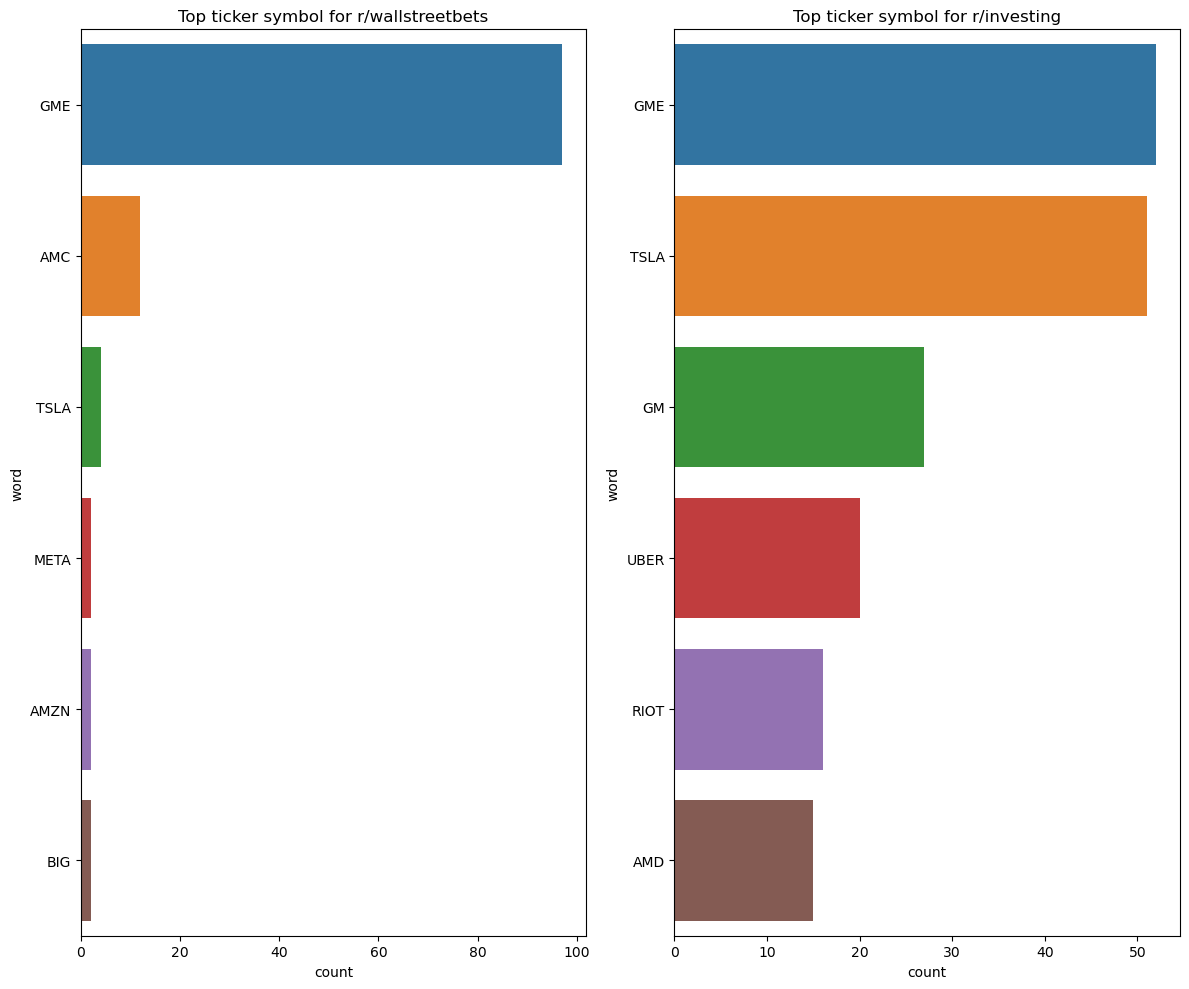

In [192]:
# Plot a horizontal bar chart for 

fig, (ax_wsb, ax_invt) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,10))

# Plotting bar chart for r/wallstreetbets
sns.barplot(data = wsb_top6, y = 'word', x = 'count', ax = ax_wsb)

# Plotting bar chart for r/investing
sns.barplot(data = invt_top6, y = 'word', x = 'count',  ax = ax_invt)

ax_wsb.set(title = 'Top ticker symbol for r/wallstreetbets')
ax_invt.set(title = 'Top ticker symbol for r/investing')

plt.tight_layout()

plt.show

### With this, we will be choosing the top 4 stocks from each subreddits there are overlaps of GME and TSLA for both subreddit, we will then choose the subsequent top 4 of r/investing. As such, below are the stocks that we will be taking a deeper look at

r/wallstreetbets:
1. GME
2. AMC
3. TSLA
4. META

r/investing:
1. GM
2. UBER
3. RIOT
4. AMD